In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.transform import rescale

from sladsnet.input_params import ERDInputParams, GeneralInputParams, SampleParams
from sladsnet.code.measurement_interface import TransmissionSimulationMeasurementInterface, ExperimentMeasurementInterface
from sladsnet.code.erd import SladsSklearnModel
from sladsnet.code.results import Result
from sladsnet.code.base import ExperimentalSample, Sample
from sladsnet.code.sampling import run_sampling
from sladsnet.code.utils import renormalize
from sladsnet.utils.readMDA import readMDA

In [3]:
from skimage.metrics import structural_similarity, mean_squared_error

In [4]:
cm = mpl.cm.viridis.copy()
#cm.set_bad('black')
cnorm = mpl.colors.LogNorm

In [5]:
def clean_and_normalize(x):
    x = np.nan_to_num(x, nan=0, posinf=0, neginf=0)
    x = (x - x.min()) / (x.max() - x.min())
    return x
    

In [6]:
C_VALUE = 2
train_base_path = Path.cwd().parent.parent / 'ResultsAndData/TrainingData/cameraman/'
erd_model = SladsSklearnModel(load_path=train_base_path / f'c_{C_VALUE}/erd_model_relu.pkl')

In [7]:
mda = readMDA('26idbSOFT_0129.mda')

26idbSOFT_0129.mda is a 2-D file; 2 dimensions read in.
dim[0] = dictionary of 8 scan-environment PVs
   usage: dim[0]['sampleEntry'] -> ('description', 'unit string', 'value')
dim[1] = 1D data from "26idbSOFT:scan2": 81/81 pts; 1 pos's, 0 dets, 2 trigs
dim[2] = 2D data from "26idbSOFT:scan1": 401/401 pts; 1 pos's, 70 dets, 3 trigs
   usage: dim[1].p[2].data -> 1D array of positioner 2 data
   usage: dim[2].d[7].data -> 2D array of detector 7 data


## Running for mda[2].d[3]

In [8]:
int1 = np.array(mda[2].d[3].data)
xrf = np.array(mda[2].d[6].data)

In [9]:
normalized_int = renormalize(int1**0.5 * xrf**0.5)

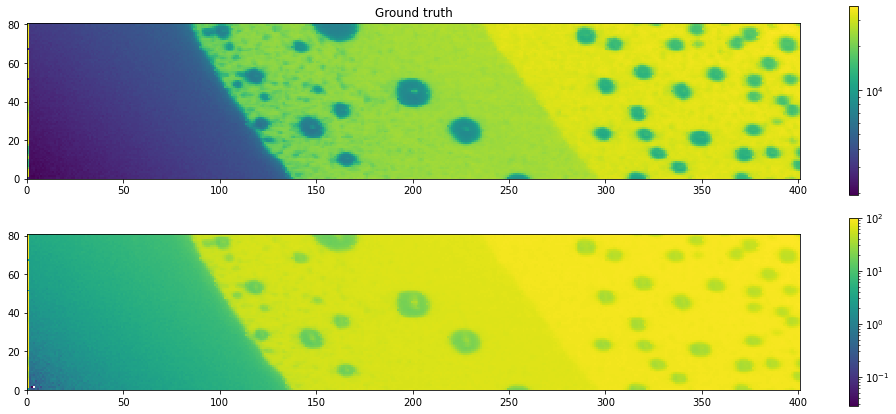

In [10]:
fig, axs = plt.subplots(2, 1, figsize=[14,6])
plt.subplot(2,1,1)
plt.pcolormesh(int1, cmap=cm, norm=cnorm())
plt.gca().set_aspect('equal')
plt.title('Ground truth')
plt.colorbar()
plt.subplot(2,1,2)
plt.pcolormesh(normalized_int, cmap=cm, norm=cnorm())
plt.gca().set_aspect('equal')
plt.colorbar()
plt.tight_layout()


In [11]:
inner_batch_size = 100
initial_scan_points_num = 500

stop_ratio = 0.9
store_results_percentage = 1

affected_neighbors_window_min = 5
affected_neighbors_window_max = 15
full_erd_recalculation_frequency = 1

In [12]:
params_erd = ERDInputParams(c_value=C_VALUE,
                            full_erd_recalculation_frequency=full_erd_recalculation_frequency,
                            affected_neighbors_window_min=affected_neighbors_window_min,
                            affected_neighbors_window_max=affected_neighbors_window_max)
params_gen = GeneralInputParams()

sample_params = SampleParams(image_shape=normalized_int.shape,
                             inner_batch_size=inner_batch_size,
                             initial_scan_points_num=initial_scan_points_num,
                             initial_scan_ratio=None,
                             stop_ratio=stop_ratio,
                             random_seed=11)


#measurement_interface = ExperimentMeasurementInterface()#'instructions.csv', num_initial_idxs= 2000)
#interface.perform_measurement(sample_params.initial_idxs)
measurement_interface = TransmissionSimulationMeasurementInterface(image=normalized_int)

In [13]:
sample = Sample(sample_params=sample_params,
                general_params=params_gen,
                erd_params=params_erd,
                measurement_interface=measurement_interface,
                erd_model=erd_model)
results = Result()

In [14]:
run_sampling(sample, results=results, results_frequency_step=1, results_frequency_percentage=0, 
             disable_progress_bar=False, debug=False, indices_to_actually_measure=50)

No more improvements expected. Stopping scan.


(<sladsnet.code.results.Result at 0x105639360>, 321)

In [15]:
erds = results.outputs.erds
total_erds = np.sum(erds, axis=(1,2))

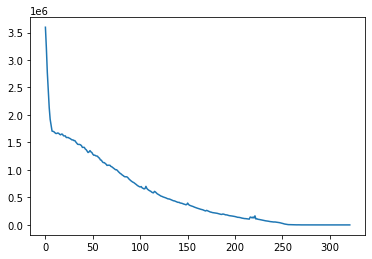

In [16]:
plt.plot(total_erds)

In [17]:
total_erds

array([3.59582900e+06, 3.21866550e+06, 2.77420600e+06, 2.46610350e+06,
       2.13545550e+06, 1.92121838e+06, 1.81017425e+06, 1.70614900e+06,
       1.70211250e+06, 1.69437500e+06, 1.67716150e+06, 1.66333338e+06,
       1.66388250e+06, 1.67273700e+06, 1.66606325e+06, 1.64826550e+06,
       1.63906362e+06, 1.65255312e+06, 1.64965938e+06, 1.62161912e+06,
       1.61857338e+06, 1.61932350e+06, 1.58967850e+06, 1.58983000e+06,
       1.59027075e+06, 1.57930312e+06, 1.57162012e+06, 1.55873150e+06,
       1.54653325e+06, 1.54728050e+06, 1.53390738e+06, 1.53468788e+06,
       1.50970925e+06, 1.48923662e+06, 1.46719775e+06, 1.46379412e+06,
       1.46432375e+06, 1.45669600e+06, 1.44245925e+06, 1.41040450e+06,
       1.40985125e+06, 1.41131700e+06, 1.38151450e+06, 1.36796825e+06,
       1.34317088e+06, 1.31690500e+06, 1.32771112e+06, 1.35147275e+06,
       1.32871225e+06, 1.31634750e+06, 1.28626662e+06, 1.26731912e+06,
       1.27021612e+06, 1.25765488e+06, 1.25393750e+06, 1.24920488e+06,
      

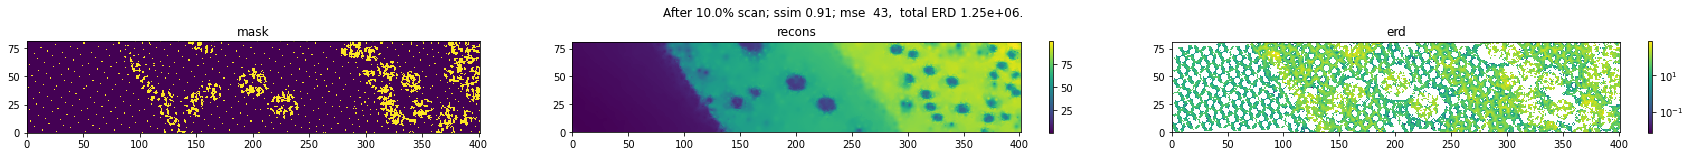

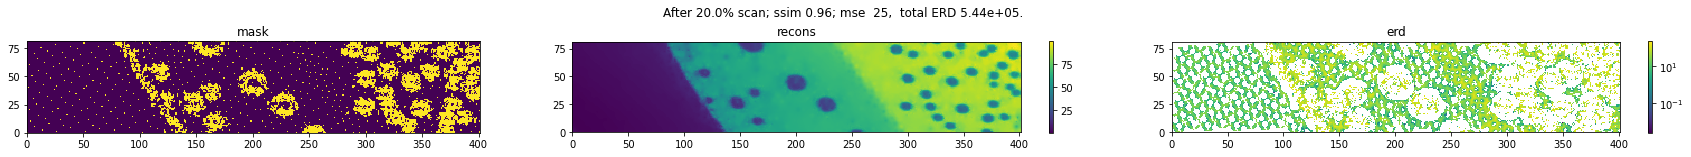

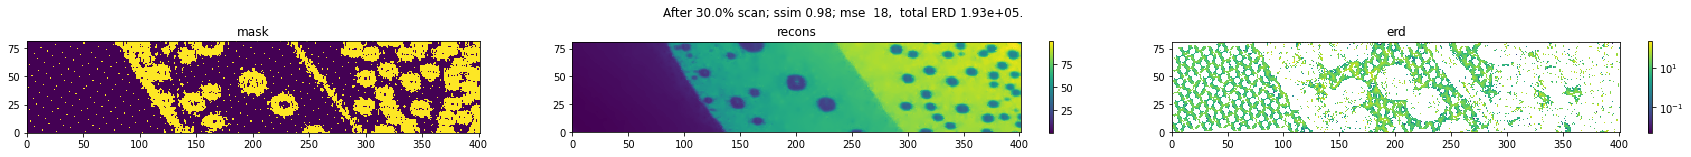

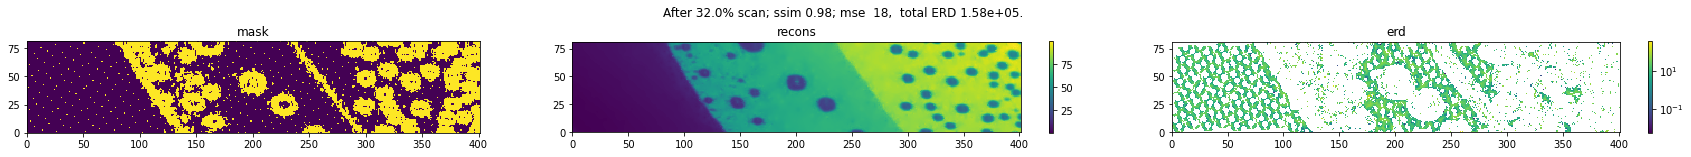

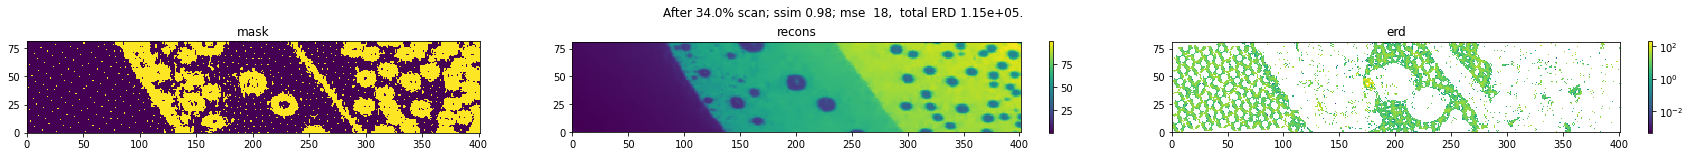

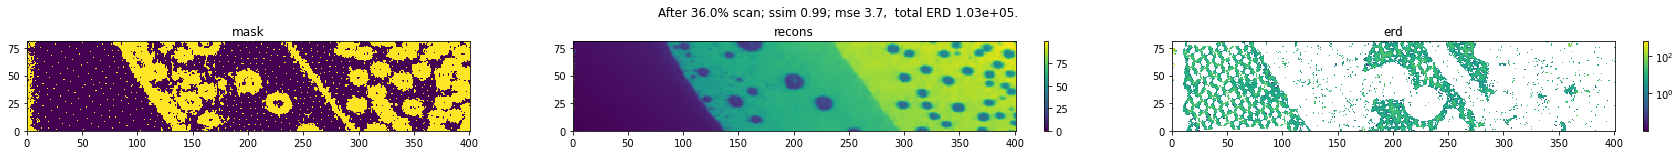

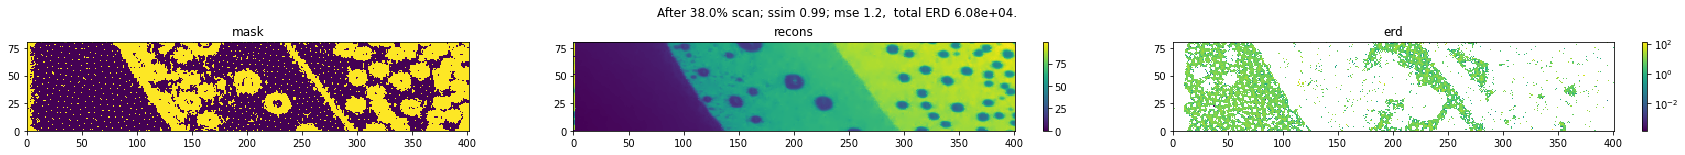

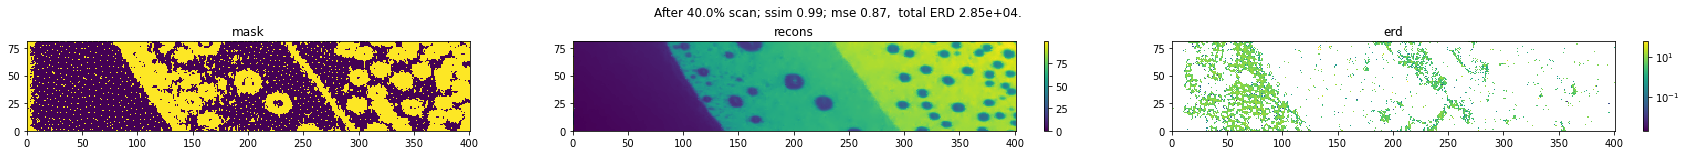

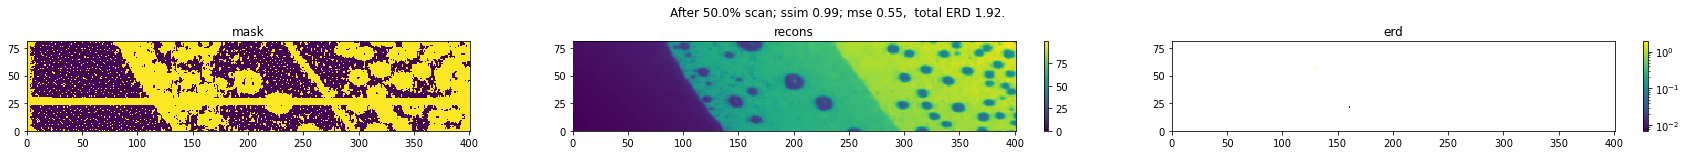

In [18]:
for i in range(results.size):
    #scan_ratio = (i + 1) * 0.1
    #percent = int(scan_ratio * 100)
    
    #if percent >= results.size:
    #    percent = results.size - 1
    
    actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 1)
    #percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
    percent = actual_percent
    if percent not in [10, 20, 30, 32, 34, 36, 37, 38, 39, 40, 50, 52, 53]: continue
    
    
    fig, axs = plt.subplots(1, 3, figsize=[25, 2])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[i])
    plt.gca().set_aspect('equal')
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[i], cmap=cm)
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    #err = measurement_interface.image - results.outputs.recons[i]
    plt.pcolormesh(results.outputs.erds[i], cmap=cm, norm=cnorm())#measurement_interface.image - results.outputs.recons[i])
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('erd')
    
    ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
    erd_this = results.outputs.erds[i].sum()
    
    plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
                 f' total ERD {erd_this:4.3g}.')
    plt.tight_layout()
    plt.show()


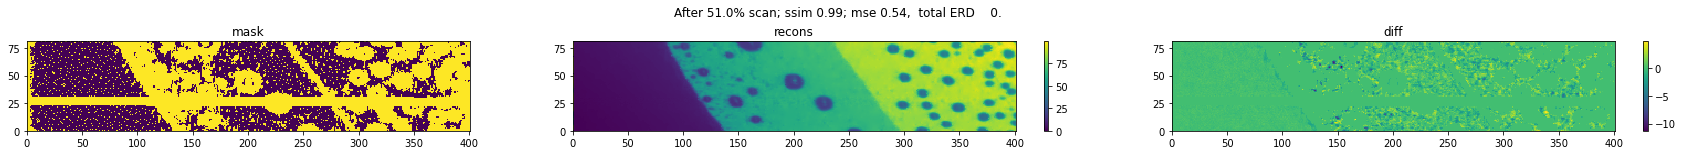

In [21]:
i = -1
actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 1)
#percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
percent = actual_percent
#if percent not in [10, 20, 30]: continue


fig, axs = plt.subplots(1, 3, figsize=[25, 2])
plt.subplot(1, 3, 1)
plt.pcolormesh(results.outputs.masks[i])
plt.gca().set_aspect('equal')
plt.title('mask')
plt.subplot(1, 3, 2)
plt.pcolormesh(results.outputs.recons[i], cmap=cm)
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('recons')
plt.subplot(1, 3, 3)
err = measurement_interface.image - results.outputs.recons[i]
plt.pcolormesh(measurement_interface.image - results.outputs.recons[i])
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('diff')

ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                             data_range=255)
mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
erd_this = results.outputs.erds[i].sum()

plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
             f' total ERD {erd_this:4.3g}.')
plt.tight_layout()
plt.show()

### Running the scan on the log 

In [28]:

log_int = renormalize(clean_and_normalize(np.log(int1 * xrf)))

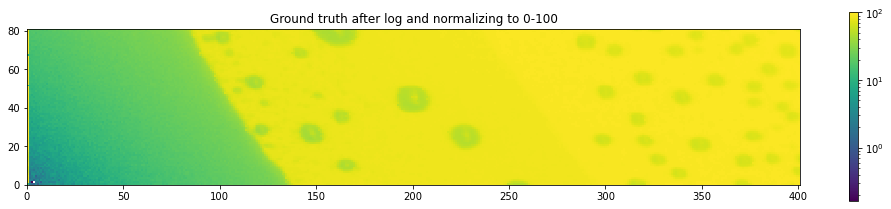

In [29]:
fig, axs = plt.subplots(1, 1, figsize=[14, 3])
plt.subplot(1,1,1)
plt.pcolormesh(log_int, cmap=cm, norm=cnorm())
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('Ground truth after log and normalizing to 0-100')
plt.tight_layout()

In [30]:
params_erd = ERDInputParams(c_value=C_VALUE,
                            full_erd_recalculation_frequency=full_erd_recalculation_frequency,
                            affected_neighbors_window_min=affected_neighbors_window_min,
                            affected_neighbors_window_max=affected_neighbors_window_max)
params_gen = GeneralInputParams()

sample_params = SampleParams(image_shape=log_int.shape,
                             inner_batch_size=inner_batch_size,
                             initial_scan_points_num=initial_scan_points_num,
                             initial_scan_ratio=None,
                             stop_ratio=stop_ratio,
                             random_seed=11)


#measurement_interface = ExperimentMeasurementInterface()#'instructions.csv', num_initial_idxs= 2000)
#interface.perform_measurement(sample_params.initial_idxs)
measurement_interface = TransmissionSimulationMeasurementInterface(image=log_int)

In [31]:
sample = Sample(sample_params=sample_params,
                general_params=params_gen,
                erd_params=params_erd,
                measurement_interface=measurement_interface,
                erd_model=erd_model)
results = Result()

In [32]:
run_sampling(sample, results=results, results_frequency_step=1, results_frequency_percentage=0, 
             disable_progress_bar=False, debug=False, indices_to_actually_measure=50)

No more improvements expected. Stopping scan.


(<sladsnet.code.results.Result at 0x1264b22f0>, 251)

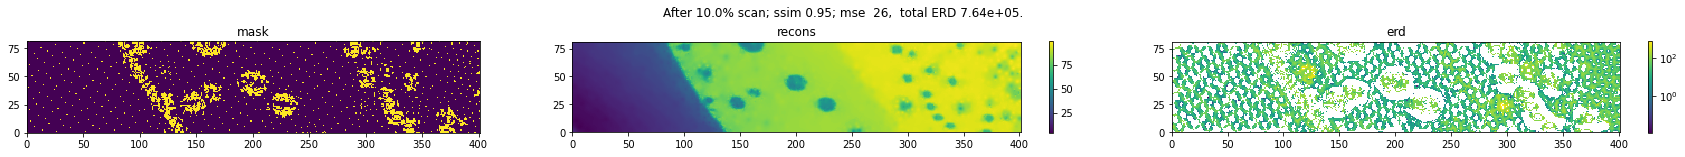

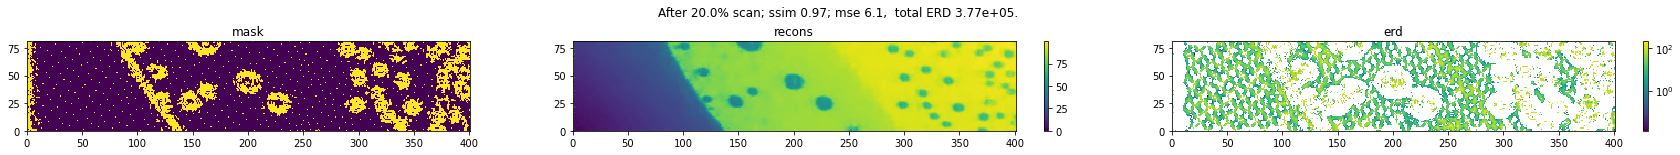

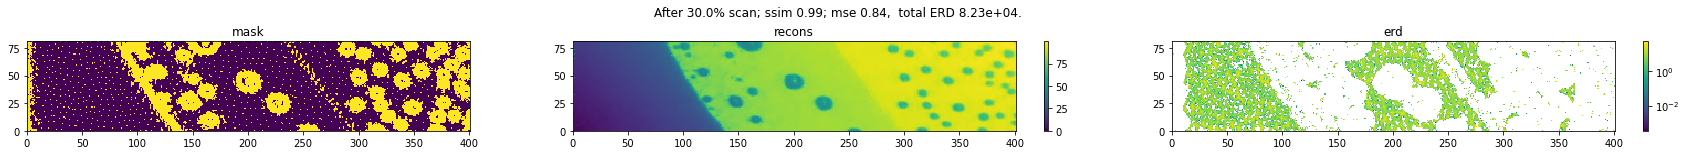

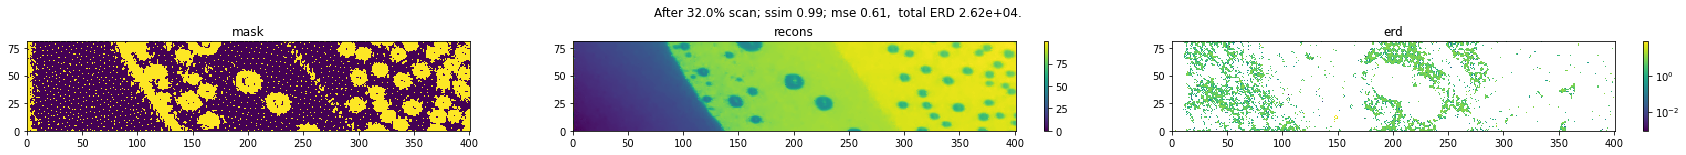

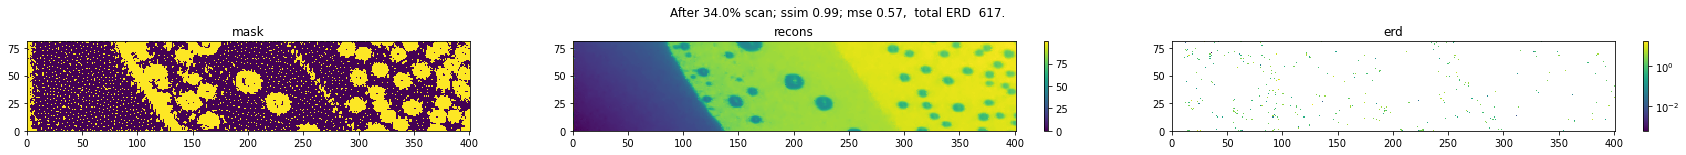

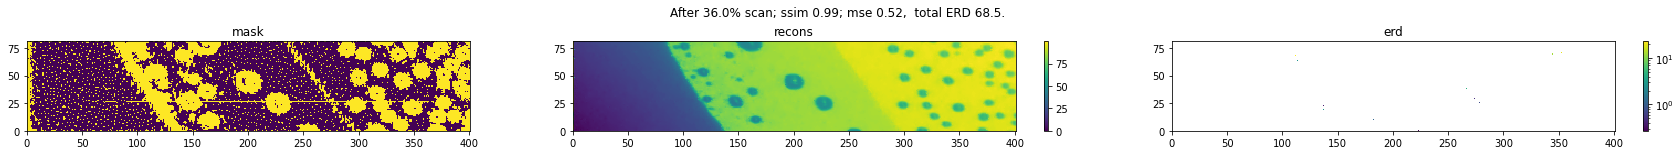

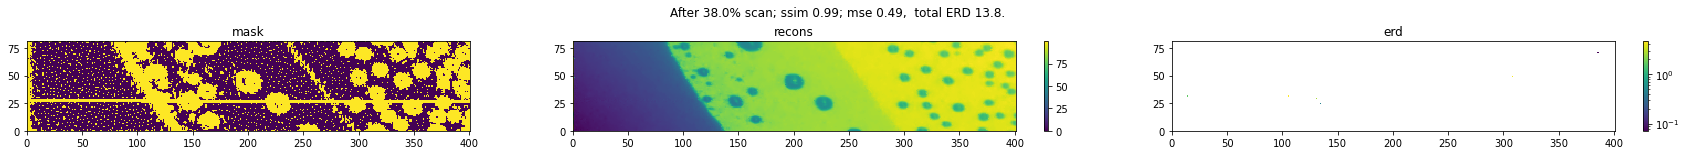

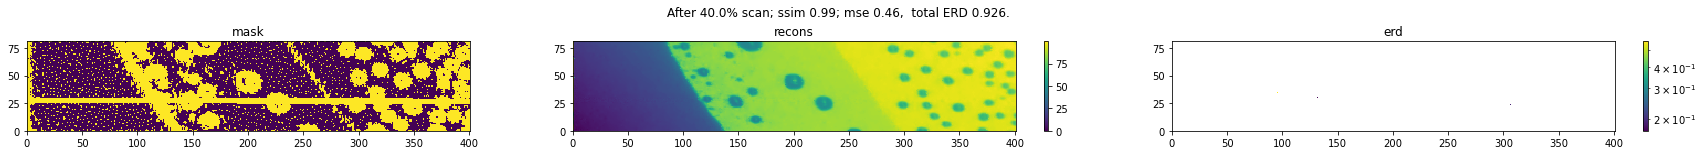

In [33]:
for i in range(results.size):
    #scan_ratio = (i + 1) * 0.1
    #percent = int(scan_ratio * 100)
    
    #if percent >= results.size:
    #    percent = results.size - 1
    
    actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 1)
    #percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
    percent = actual_percent
    if percent not in [10, 20, 30, 32, 34, 36, 37, 38, 39, 40, 50, 52, 53]: continue
    
    
    fig, axs = plt.subplots(1, 3, figsize=[25, 2])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[i])
    plt.gca().set_aspect('equal')
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[i], cmap=cm)
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    #err = measurement_interface.image - results.outputs.recons[i]
    plt.pcolormesh(results.outputs.erds[i], cmap=cm, norm=cnorm())#measurement_interface.image - results.outputs.recons[i])
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('erd')
    
    ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
    erd_this = results.outputs.erds[i].sum()
    
    plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
                 f' total ERD {erd_this:4.3g}.')
    plt.tight_layout()
    plt.show()


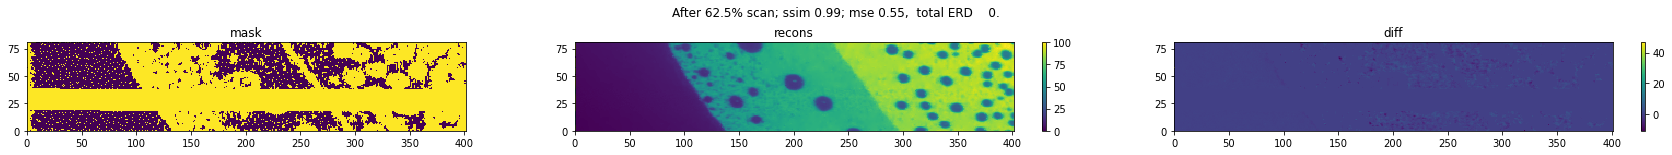

In [226]:
for i in range(results.size):
    #scan_ratio = (i + 1) * 0.1
    #percent = int(scan_ratio * 100)
    
    #if percent >= results.size:
    #    percent = results.size - 1
    
    actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 1)
    #percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
    percent = actual_percent
    if percent not in [51]: continue
    
    
    fig, axs = plt.subplots(1, 3, figsize=[25, 2])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[i])
    plt.gca().set_aspect('equal')
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[i], cmap=cm)
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    err = measurement_interface.image - results.outputs.recons[i]
    plt.pcolormesh(measurement_interface.image - results.outputs.recons[i])
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('diff')
    
    ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
    erd_this = results.outputs.erds[i].sum()
    
    plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
                 f' total ERD {erd_this:4.3g}.')
    plt.tight_layout()
    plt.show()


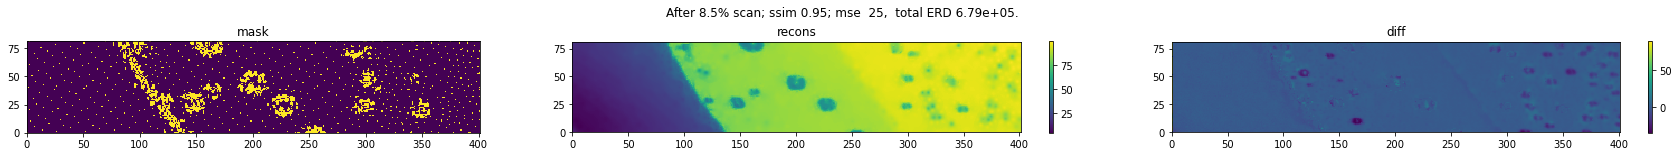

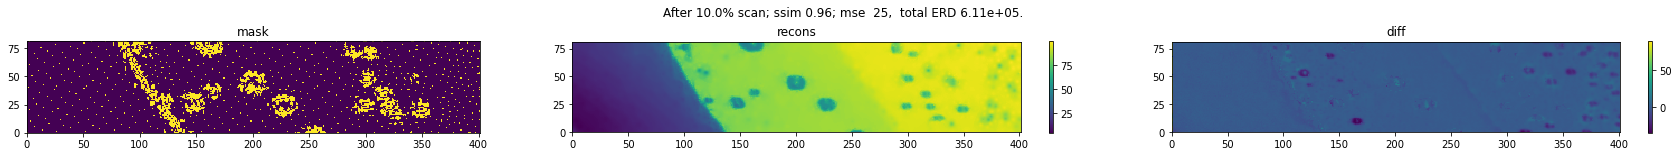

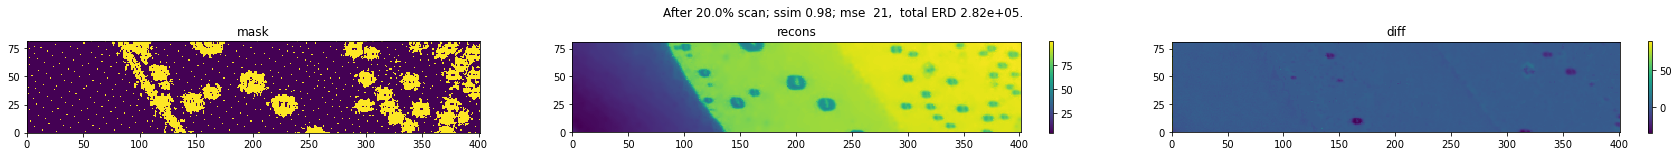

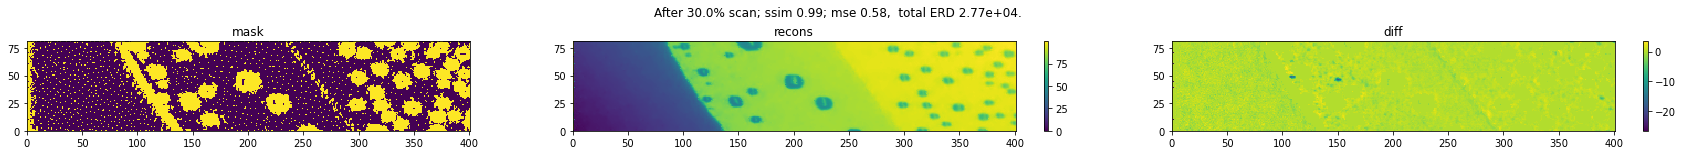

In [189]:
for i in range(results.size):
    #scan_ratio = (i + 1) * 0.1
    #percent = int(scan_ratio * 100)
    
    #if percent >= results.size:
    #    percent = results.size - 1
    
    actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 1)
    #percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
    percent = actual_percent
    #print(actual_percent)
    if percent not in [8.5, 10, 20, 30]: continue
    
    
    fig, axs = plt.subplots(1, 3, figsize=[25, 2])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[i])
    plt.gca().set_aspect('equal')
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[i], cmap=cm)
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    err = measurement_interface.image - results.outputs.recons[i]
    plt.pcolormesh(measurement_interface.image - results.outputs.recons[i])
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('diff')
    
    ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
    erd_this = results.outputs.erds[i].sum()
    
    plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
                 f' total ERD {erd_this:4.3g}.')
    plt.tight_layout()
    plt.show()


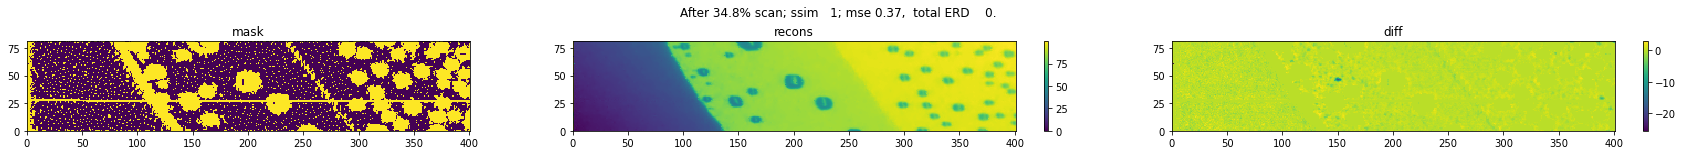

In [190]:
i = -1
actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 1)
#percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
percent = actual_percent
#if percent not in [10, 20, 30]: continue


fig, axs = plt.subplots(1, 3, figsize=[25, 2])
plt.subplot(1, 3, 1)
plt.pcolormesh(results.outputs.masks[i])
plt.gca().set_aspect('equal')
plt.title('mask')
plt.subplot(1, 3, 2)
plt.pcolormesh(results.outputs.recons[i], cmap=cm)
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('recons')
plt.subplot(1, 3, 3)
err = measurement_interface.image - results.outputs.recons[i]
plt.pcolormesh(measurement_interface.image - results.outputs.recons[i])
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('diff')

ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                             data_range=255)
mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
erd_this = results.outputs.erds[i].sum()

plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
             f' total ERD {erd_this:4.3g}.')
plt.tight_layout()
plt.show()

In [150]:
erds = results.outputs.erds
total_erds = np.sum(erds, axis=(1,2))

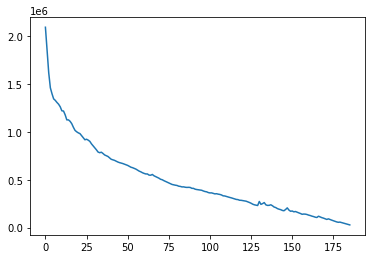

In [151]:
plt.plot(total_erds)

In [152]:
total_erds

array([2092872.1  , 1848517.   , 1618398.4  , 1460204.9  , 1398000.8  ,
       1344608.9  , 1328728.8  , 1307195.8  , 1288911.8  , 1261819.2  ,
       1219512.8  , 1217727.2  , 1177884.8  , 1125155.1  , 1125185.8  ,
       1110162.6  , 1085396.6  , 1047697.8  , 1015195.94 , 1000587.1  ,
        989379.2  ,  981457.06 ,  959502.3  ,  937022.56 ,  917285.75 ,
        922795.3  ,  913401.1  ,  900453.5  ,  874425.6  ,  854273.6  ,
        834531.4  ,  812336.4  ,  788980.6  ,  781996.5  ,  787204.5  ,
        773801.4  ,  758632.7  ,  750650.6  ,  742843.6  ,  727958.1  ,
        713387.9  ,  707338.25 ,  702159.56 ,  693742.44 ,  685003.56 ,
        678635.06 ,  673775.6  ,  669001.8  ,  662620.3  ,  655394.5  ,
        649391.44 ,  639291.   ,  630285.5  ,  625396.2  ,  617998.3  ,
        610741.5  ,  599519.1  ,  589540.94 ,  582228.56 ,  572756.25 ,
        565722.   ,  560096.7  ,  560075.44 ,  547945.9  ,  547025.06 ,
        554646.1  ,  540824.9  ,  532400.5  ,  523664.94 ,  5158

## Running for int combined with com

In [39]:
comx = np.array(mda[2].d[11].data)
comy = np.array(mda[2].d[12].data)

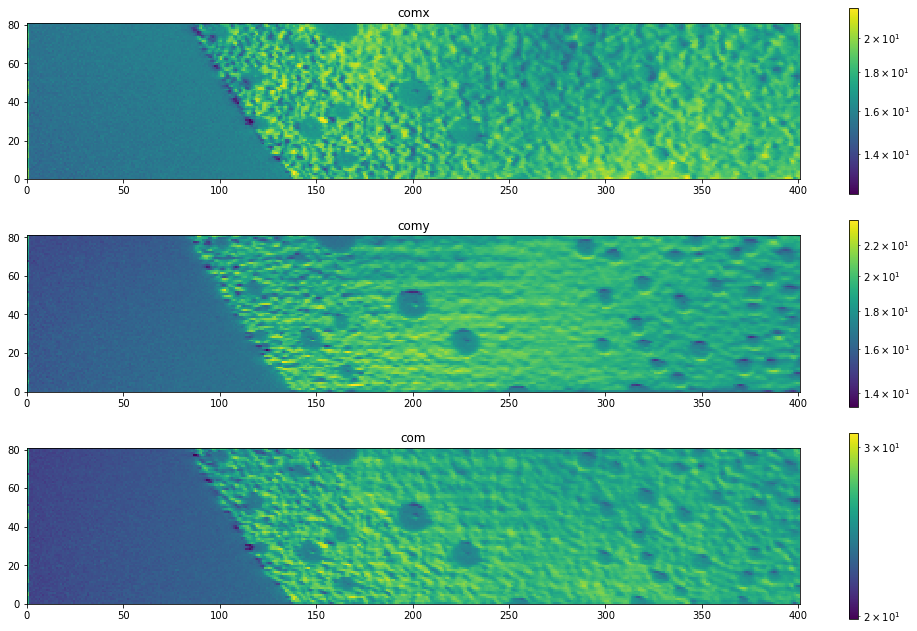

In [66]:
fig, axs = plt.subplots(3, 1, figsize=[14,9])
plt.subplot(3,1,1)
plt.pcolormesh(comx, cmap=cm, norm=cnorm())
plt.gca().set_aspect('equal')
plt.title('comx')
plt.colorbar()
plt.subplot(3,1,2)
plt.pcolormesh(comy, cmap=cm, norm=cnorm())
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('comy')
plt.subplot(3,1,3)
plt.pcolormesh((comy**2 + comx**2)**0.5, cmap=cm, norm=cnorm())
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('com')
plt.tight_layout()


In [153]:
int1 = np.array(mda[2].d[6].data)

In [161]:
normalized_comy = renormalize((np.abs(comy)**2 + np.abs(comx)**2)* int1)

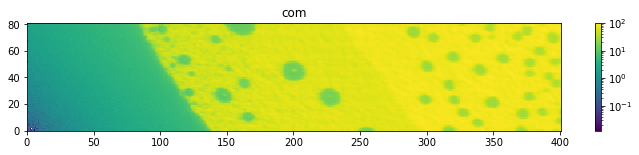

In [162]:
plt.figure(figsize=(10,2))
plt.pcolormesh(normalized_comy, cmap=cm, norm=cnorm())
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('com')
plt.tight_layout()

In [163]:
inner_batch_size = 100
initial_scan_points_num = 500

stop_ratio = 0.9
store_results_percentage = 1

affected_neighbors_window_min = 5
affected_neighbors_window_max = 15
full_erd_recalculation_frequency = 1

In [164]:
params_erd = ERDInputParams(c_value=C_VALUE,
                            full_erd_recalculation_frequency=full_erd_recalculation_frequency,
                            affected_neighbors_window_min=affected_neighbors_window_min,
                            affected_neighbors_window_max=affected_neighbors_window_max)
params_gen = GeneralInputParams()

sample_params = SampleParams(image_shape=normalized_comy.shape,
                             inner_batch_size=inner_batch_size,
                             initial_scan_points_num=initial_scan_points_num,
                             initial_scan_ratio=None,
                             stop_ratio=stop_ratio,
                             random_seed=11)


#measurement_interface = ExperimentMeasurementInterface()#'instructions.csv', num_initial_idxs= 2000)
#interface.perform_measurement(sample_params.initial_idxs)
measurement_interface = TransmissionSimulationMeasurementInterface(image=normalized_comy)

In [165]:
sample = Sample(sample_params=sample_params,
                general_params=params_gen,
                erd_params=params_erd,
                measurement_interface=measurement_interface,
                erd_model=erd_model)
results = Result()

In [ ]:
run_sampling(sample, results=results, results_frequency_step=1, results_frequency_percentage=0, 
             disable_progress_bar=False, debug=False, indices_to_actually_measure=20)

% sampled:  41%|##########################################2                                                           | 37.25/90.0 [00:54<01:16,  1.45s/it, total ERD=5.27e+5]

In [1]:
erds = results.outputs.erds
total_erds = np.sum(erds, axis=(1,2))

NameError: name 'results' is not defined

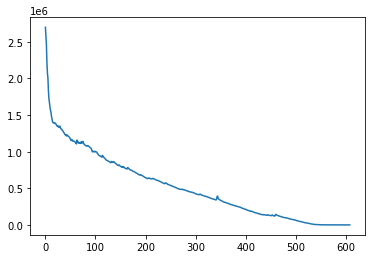

In [158]:
plt.plot(total_erds)

In [159]:
total_erds

array([2.70011250e+06, 2.58454975e+06, 2.46267900e+06, 2.21436925e+06,
       2.07614912e+06, 2.00818125e+06, 1.83730125e+06, 1.72698712e+06,
       1.66859425e+06, 1.61870562e+06, 1.56781275e+06, 1.54465050e+06,
       1.48754900e+06, 1.45224800e+06, 1.41724438e+06, 1.39665725e+06,
       1.39791212e+06, 1.39372462e+06, 1.38506238e+06, 1.39011788e+06,
       1.38965850e+06, 1.37629862e+06, 1.36148038e+06, 1.35175638e+06,
       1.35097812e+06, 1.35578625e+06, 1.33745650e+06, 1.33177775e+06,
       1.34503675e+06, 1.34951838e+06, 1.32421688e+06, 1.31266775e+06,
       1.30868638e+06, 1.30462600e+06, 1.28869062e+06, 1.28215238e+06,
       1.27126800e+06, 1.26123488e+06, 1.24820200e+06, 1.23528162e+06,
       1.23438975e+06, 1.22125100e+06, 1.21540250e+06, 1.23126225e+06,
       1.21944025e+06, 1.21735525e+06, 1.20747888e+06, 1.20204900e+06,
       1.19812425e+06, 1.18326288e+06, 1.17675000e+06, 1.15345650e+06,
       1.15424762e+06, 1.16600912e+06, 1.14762450e+06, 1.15049625e+06,
      

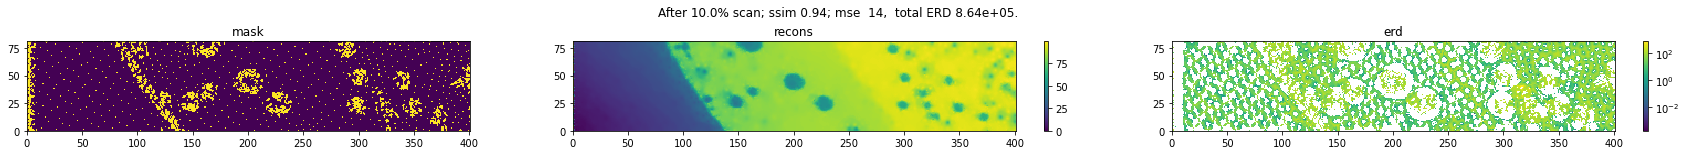

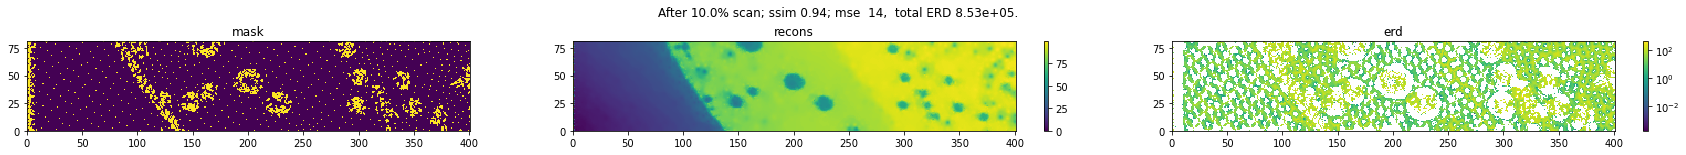

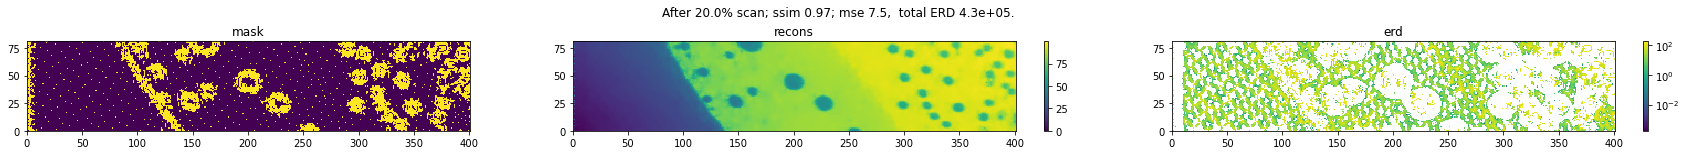

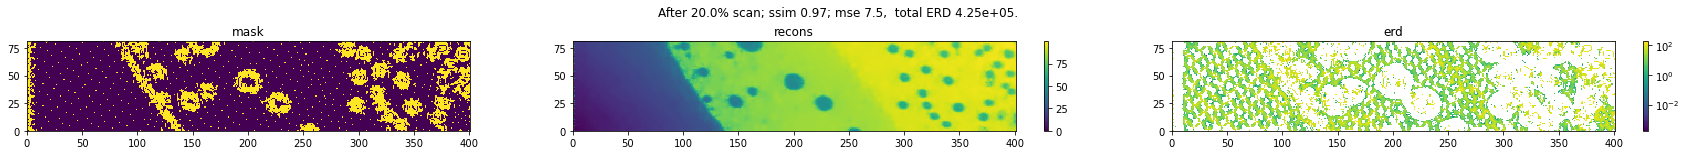

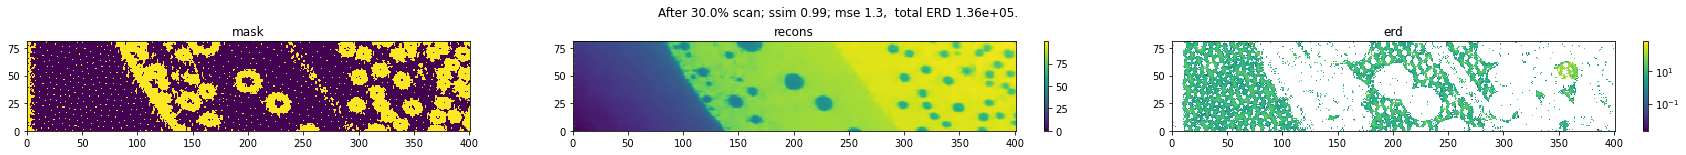

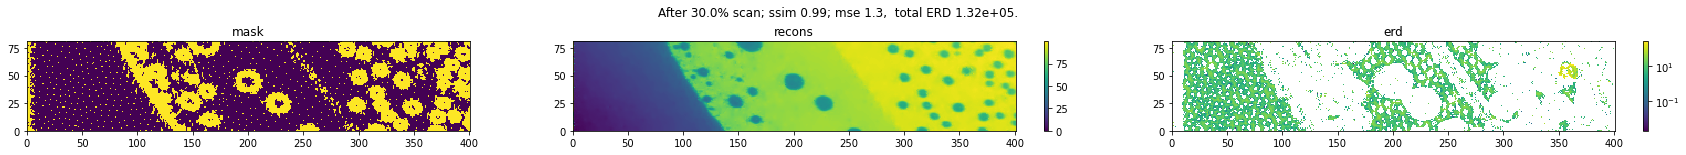

In [160]:
for i in range(results.size):
    #scan_ratio = (i + 1) * 0.1
    #percent = int(scan_ratio * 100)
    
    #if percent >= results.size:
    #    percent = results.size - 1
    
    actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 1)
    #percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
    percent = actual_percent
    if percent not in [10, 20, 30]: continue
    
    
    fig, axs = plt.subplots(1, 3, figsize=[25, 2])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[i])
    plt.gca().set_aspect('equal')
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[i], cmap=cm)
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    plt.pcolormesh(results.outputs.erds[i], cmap=cm, norm=cnorm())#measurement_interface.image - results.outputs.recons[i])
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('erd')
    
    ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
    erd_this = results.outputs.erds[i].sum()
    
    plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
                 f' total ERD {erd_this:4.3g}.')
    plt.tight_layout()
    plt.show()


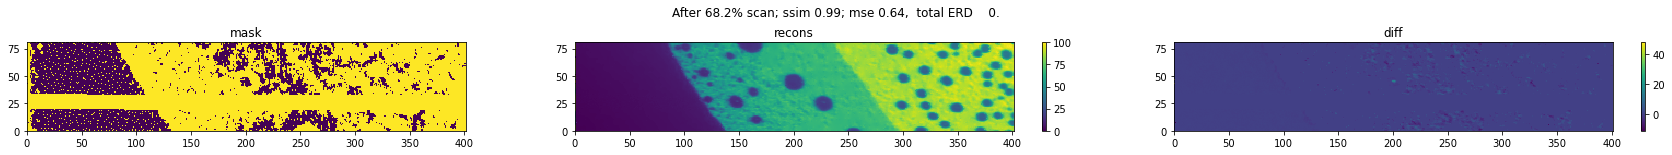

In [144]:
i = -1
actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 1)
#percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
percent = actual_percent
#if percent not in [10, 20, 30]: continue


fig, axs = plt.subplots(1, 3, figsize=[25, 2])
plt.subplot(1, 3, 1)
plt.pcolormesh(results.outputs.masks[i])
plt.gca().set_aspect('equal')
plt.title('mask')
plt.subplot(1, 3, 2)
plt.pcolormesh(results.outputs.recons[i], cmap=cm)
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('recons')
plt.subplot(1, 3, 3)
err = measurement_interface.image - results.outputs.recons[i]
plt.pcolormesh(measurement_interface.image - results.outputs.recons[i])
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('diff')

ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                             data_range=255)
mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
erd_this = results.outputs.erds[i].sum()

plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
             f' total ERD {erd_this:4.3g}.')
plt.tight_layout()
plt.show()

### Running the scan on the log 

In [165]:

log_int = renormalize(clean_and_normalize(np.log(int1)))

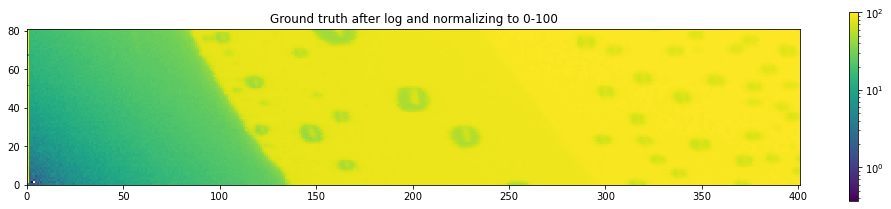

In [166]:
fig, axs = plt.subplots(1, 1, figsize=[14, 3])
plt.subplot(1,1,1)
plt.pcolormesh(log_int, cmap=cm, norm=cnorm())
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('Ground truth after log and normalizing to 0-100')
plt.tight_layout()

In [167]:
params_erd = ERDInputParams(c_value=C_VALUE,
                            full_erd_recalculation_frequency=full_erd_recalculation_frequency,
                            affected_neighbors_window_min=affected_neighbors_window_min,
                            affected_neighbors_window_max=affected_neighbors_window_max)
params_gen = GeneralInputParams()

sample_params = SampleParams(image_shape=log_int.shape,
                             inner_batch_size=inner_batch_size,
                             initial_scan_points_num=initial_scan_points_num,
                             initial_scan_ratio=None,
                             stop_ratio=stop_ratio,
                             random_seed=11)


#measurement_interface = ExperimentMeasurementInterface()#'instructions.csv', num_initial_idxs= 2000)
#interface.perform_measurement(sample_params.initial_idxs)
measurement_interface = TransmissionSimulationMeasurementInterface(image=log_int)

In [168]:
sample = Sample(sample_params=sample_params,
                general_params=params_gen,
                erd_params=params_erd,
                measurement_interface=measurement_interface,
                erd_model=erd_model)
results = Result()

In [169]:
run_sampling(sample, results=results, results_frequency_step=1, results_frequency_percentage=0, 
             disable_progress_bar=False, debug=False, indices_to_actually_measure=50)

Reached the stopping ratio set in the sample parameters. Stopping scan.


(<sladsnet.code.results.Result at 0x16bdbf6d0>, 185)

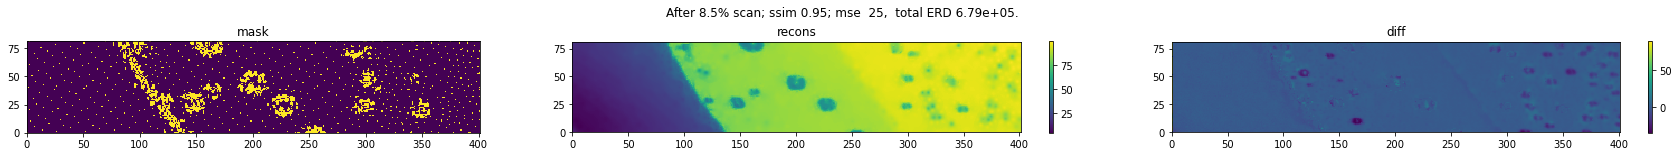

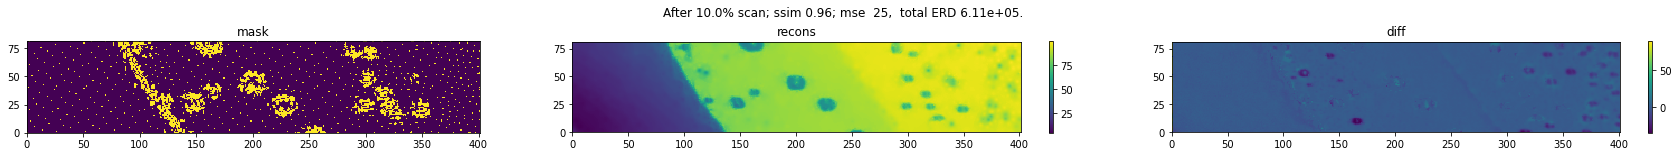

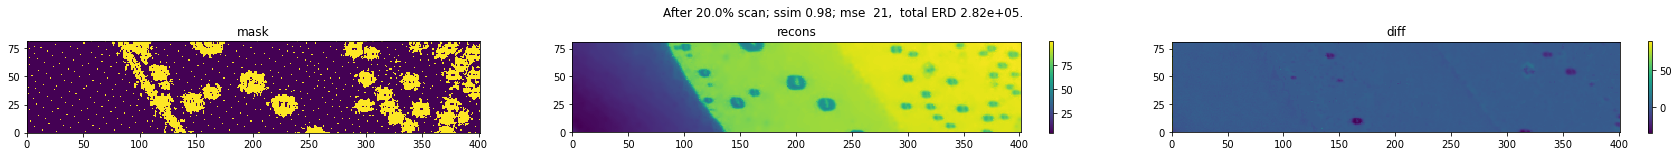

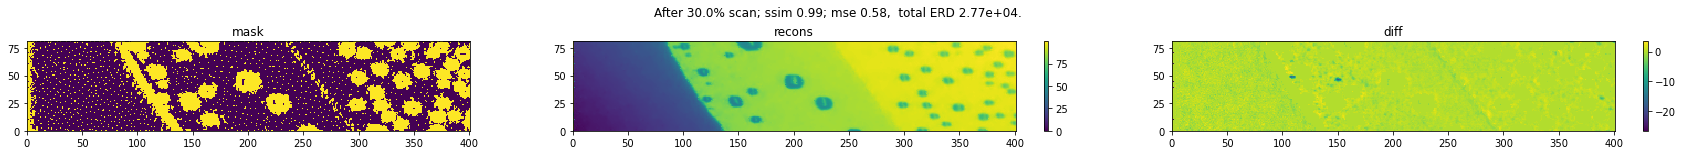

In [170]:
for i in range(results.size):
    #scan_ratio = (i + 1) * 0.1
    #percent = int(scan_ratio * 100)
    
    #if percent >= results.size:
    #    percent = results.size - 1
    
    actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 1)
    #percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
    percent = actual_percent
    #print(actual_percent)
    if percent not in [8.5, 10, 20, 30]: continue
    
    
    fig, axs = plt.subplots(1, 3, figsize=[25, 2])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[i])
    plt.gca().set_aspect('equal')
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[i], cmap=cm)
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    err = measurement_interface.image - results.outputs.recons[i]
    plt.pcolormesh(measurement_interface.image - results.outputs.recons[i])
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('diff')
    
    ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
    erd_this = results.outputs.erds[i].sum()
    
    plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
                 f' total ERD {erd_this:4.3g}.')
    plt.tight_layout()
    plt.show()


In [171]:
erds = results.outputs.erds
total_erds = np.sum(erds, axis=(1,2))

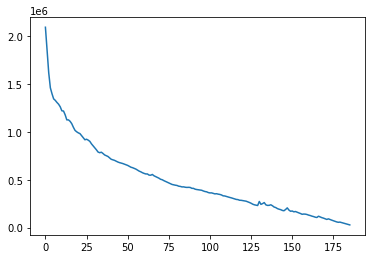

In [172]:
plt.plot(total_erds)

In [173]:
total_erds

array([2092872.1  , 1848517.   , 1618398.4  , 1460204.9  , 1398000.8  ,
       1344608.9  , 1328728.8  , 1307195.8  , 1288911.8  , 1261819.2  ,
       1219512.8  , 1217727.2  , 1177884.8  , 1125155.1  , 1125185.8  ,
       1110162.6  , 1085396.6  , 1047697.8  , 1015195.94 , 1000587.1  ,
        989379.2  ,  981457.06 ,  959502.3  ,  937022.56 ,  917285.75 ,
        922795.3  ,  913401.1  ,  900453.5  ,  874425.6  ,  854273.6  ,
        834531.4  ,  812336.4  ,  788980.6  ,  781996.5  ,  787204.5  ,
        773801.4  ,  758632.7  ,  750650.6  ,  742843.6  ,  727958.1  ,
        713387.9  ,  707338.25 ,  702159.56 ,  693742.44 ,  685003.56 ,
        678635.06 ,  673775.6  ,  669001.8  ,  662620.3  ,  655394.5  ,
        649391.44 ,  639291.   ,  630285.5  ,  625396.2  ,  617998.3  ,
        610741.5  ,  599519.1  ,  589540.94 ,  582228.56 ,  572756.25 ,
        565722.   ,  560096.7  ,  560075.44 ,  547945.9  ,  547025.06 ,
        554646.1  ,  540824.9  ,  532400.5  ,  523664.94 ,  5158